In [6]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os
from backtester.log import Log

from collections import defaultdict


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


def get_time_part(df: pd.DataFrame, l, h) -> pd.DataFrame:
    dfret = df.copy()
    dfret = dfret[(dfret["timestamp"] >= l) & (dfret["timestamp"] < h)].reset_index(drop=True)
    return dfret

In [7]:
CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

round4finallog = Log.from_file("round4final.log")


In [8]:
md = market_data_round_5_day_4.copy()
th = trades_round_5_day_4.copy()
obs = observations_round_5_day_4.copy()


 
 
print(np.max(th['quantity']))

th, md

20


(       timestamp    buyer  seller         symbol   currency    price  quantity
 0              0   Caesar   Paris           JAMS  SEASHELLS   6446.0        10
 1            200   Caesar   Paris        DJEMBES  SEASHELLS  13372.0         1
 2            200   Caesar   Paris           JAMS  SEASHELLS   6445.0         5
 3            200   Caesar  Caesar  VOLCANIC_ROCK  SEASHELLS   9919.0         6
 4            300    Paris  Caesar     CROISSANTS  SEASHELLS   4297.0         6
 ...          ...      ...     ...            ...        ...      ...       ...
 17353     999600   Caesar   Pablo  VOLCANIC_ROCK  SEASHELLS  10104.0         2
 17354     999700  Charlie   Paris           KELP  SEASHELLS   2011.0         1
 17355     999700  Charlie   Paris      SQUID_INK  SEASHELLS   1899.0         1
 17356     999700    Peter  Caesar  VOLCANIC_ROCK  SEASHELLS  10107.0        10
 17357     999800   Caesar   Paris        DJEMBES  SEASHELLS  13409.0         2
 
 [17358 rows x 7 columns],
         da

Hopefully with the exploit data we can use it to find people who are signals for various products. like if someone consistently buys at the trough and sells at the peak we just buy whenever they buy and sell whenever they sell.  

i think it makes sense to optimise for  
- products we don't have a strat for
- products we do have a strat for, but want to improve.

lets start by tracking people's PNL for an instrument, over time.  

For now we can treat the instruments as indpenedent. maybe in the future lets consider correlating their signals etc.

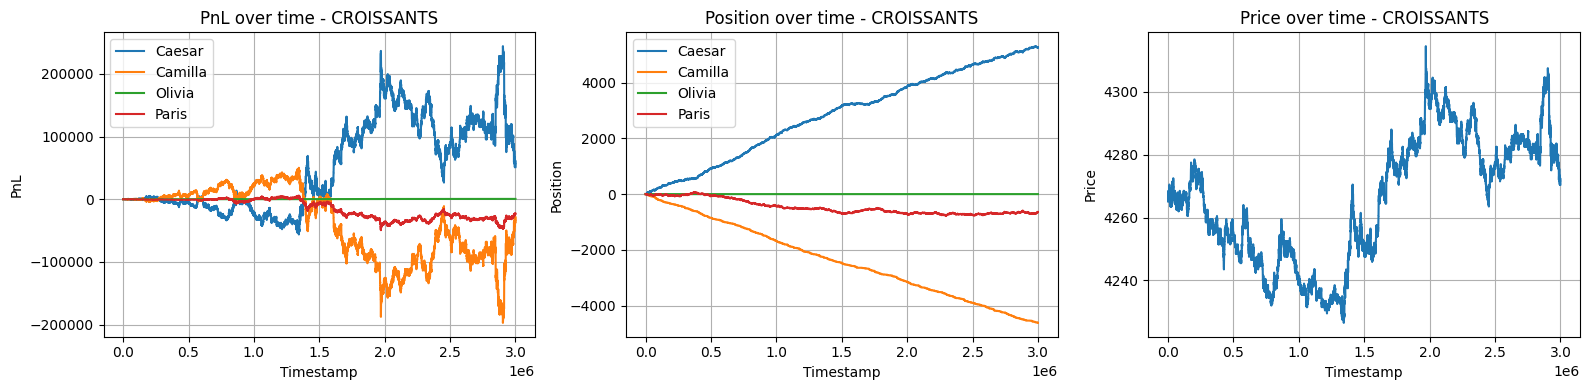

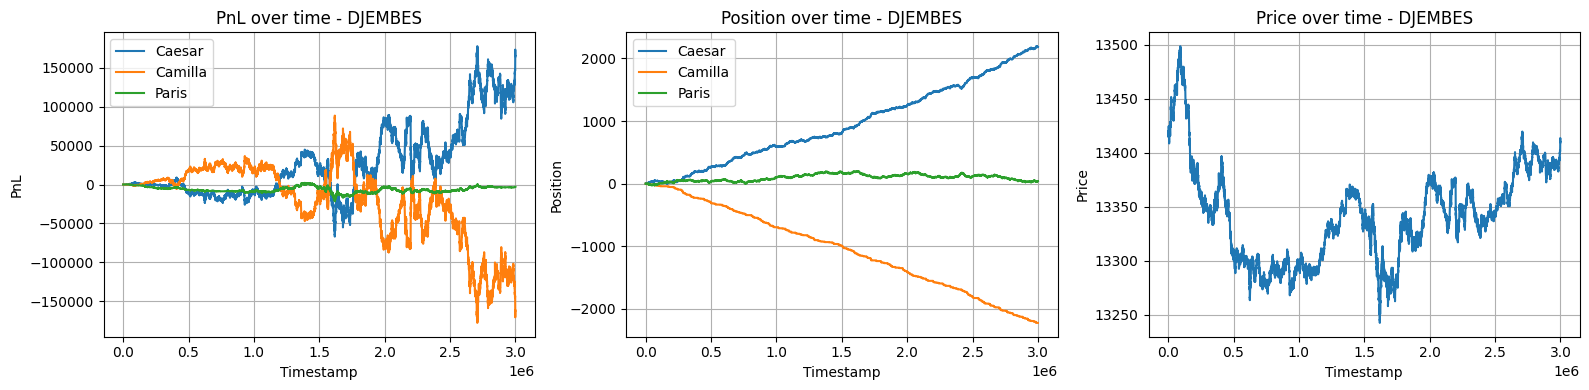

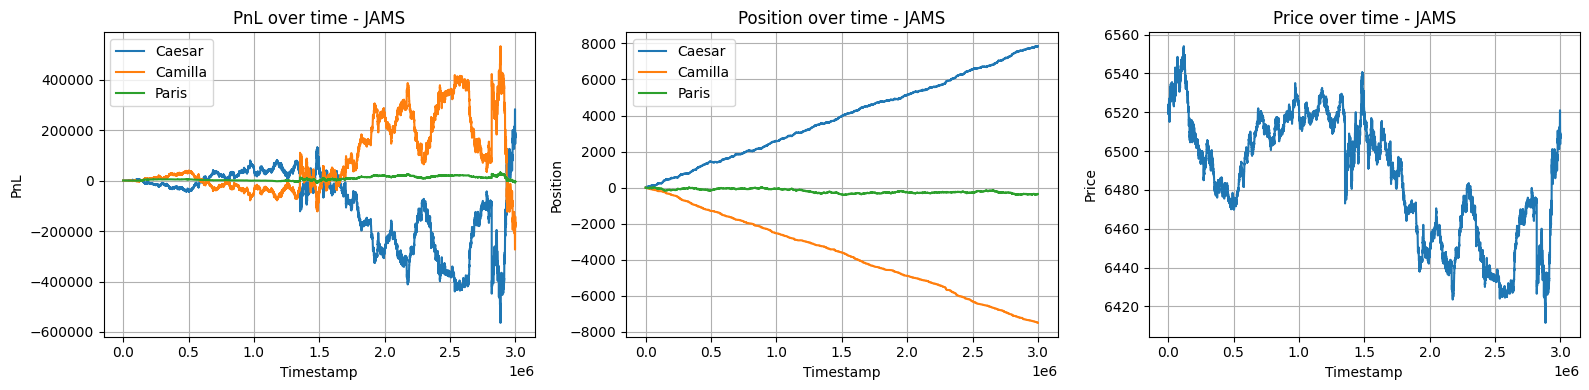

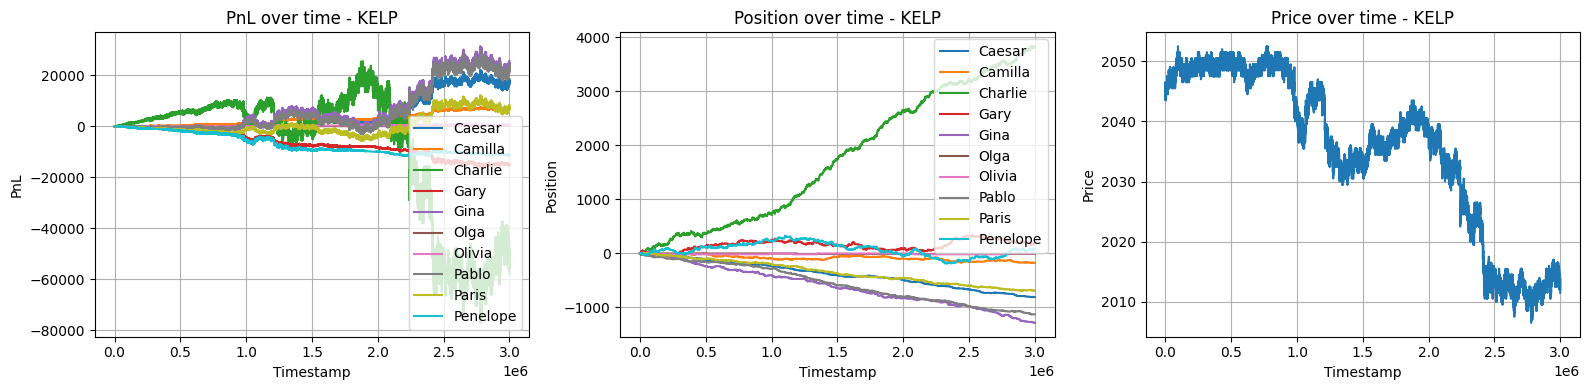

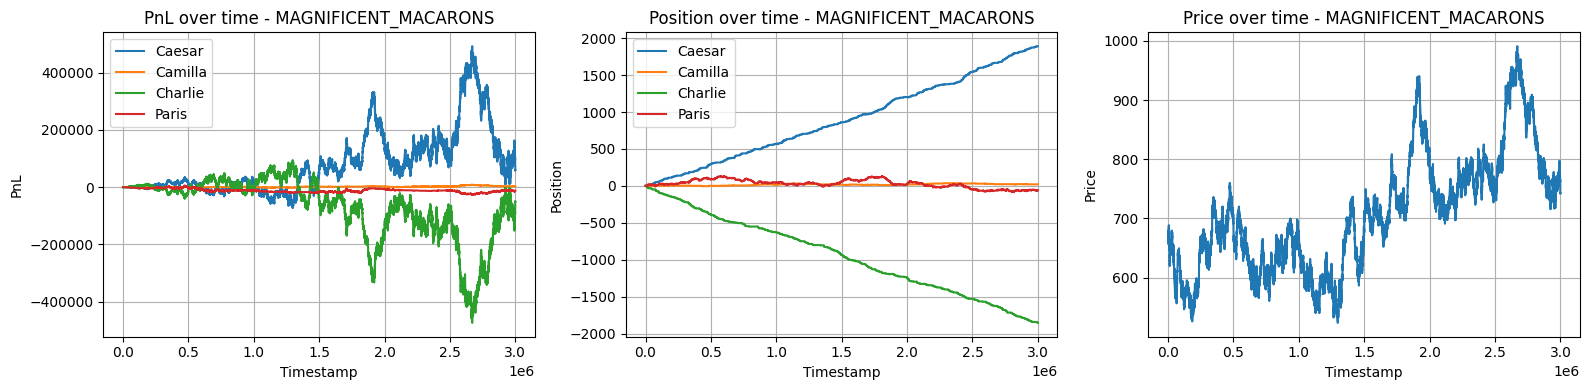

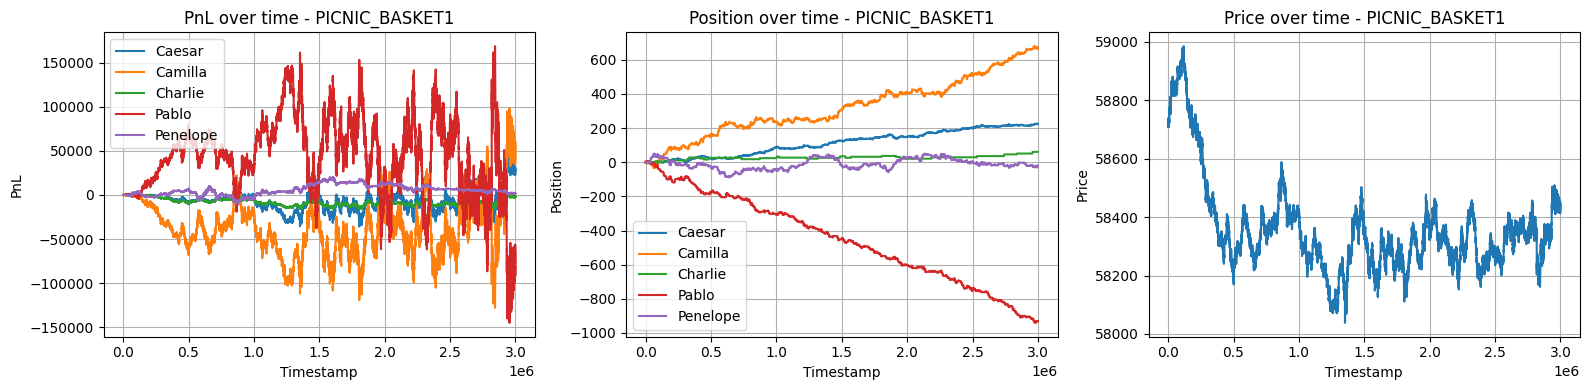

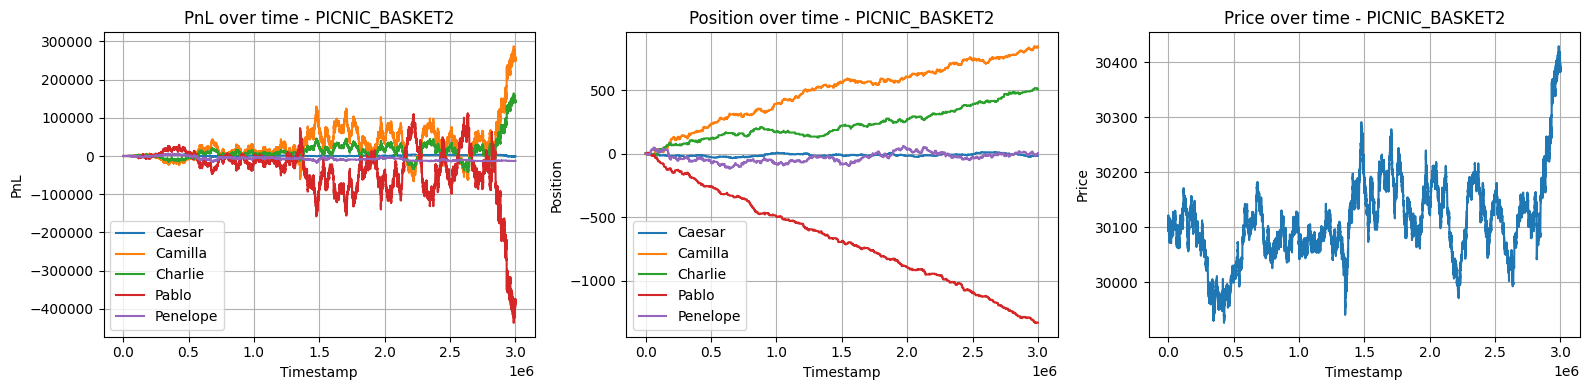

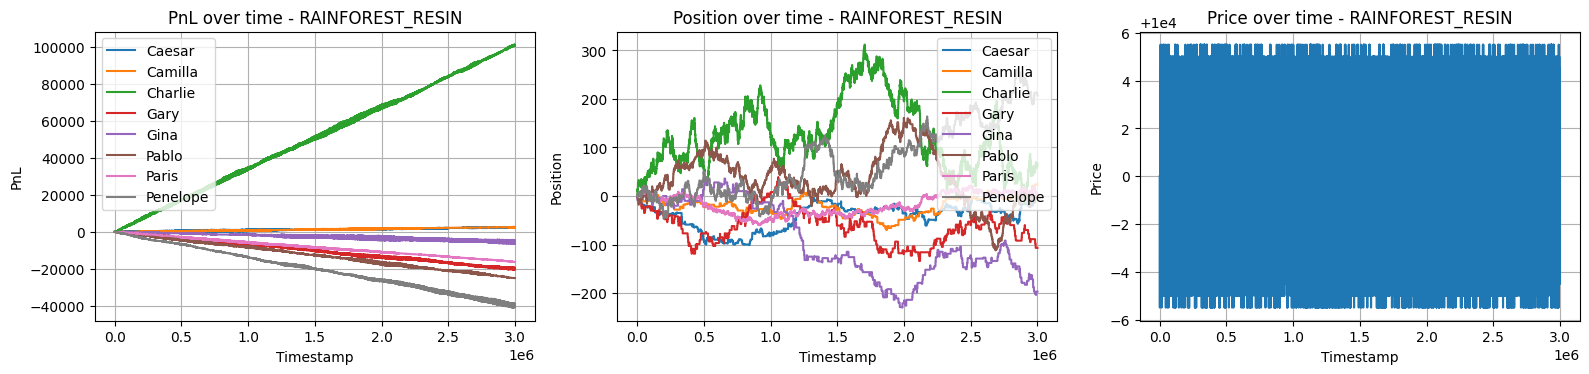

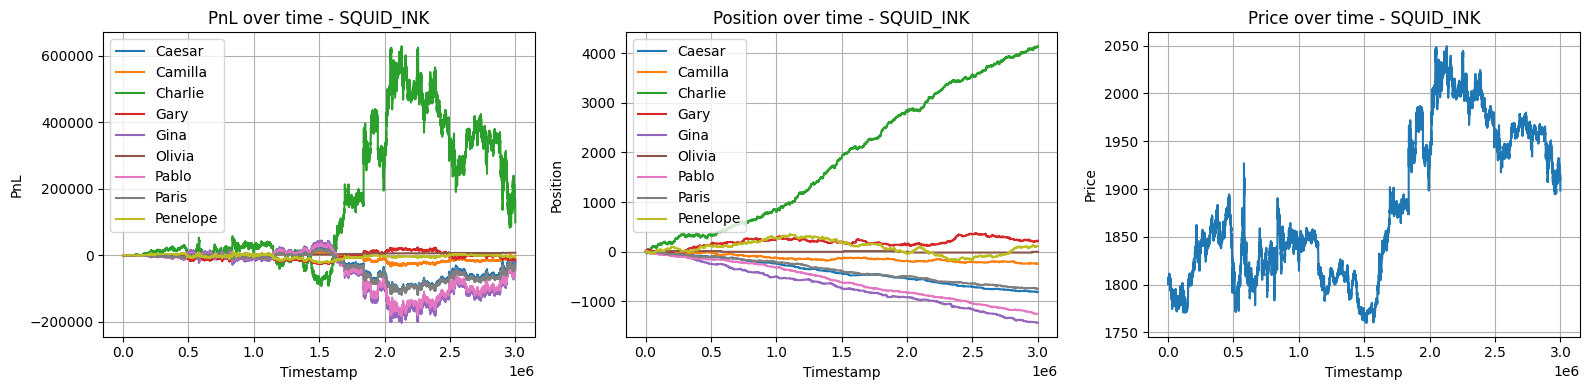

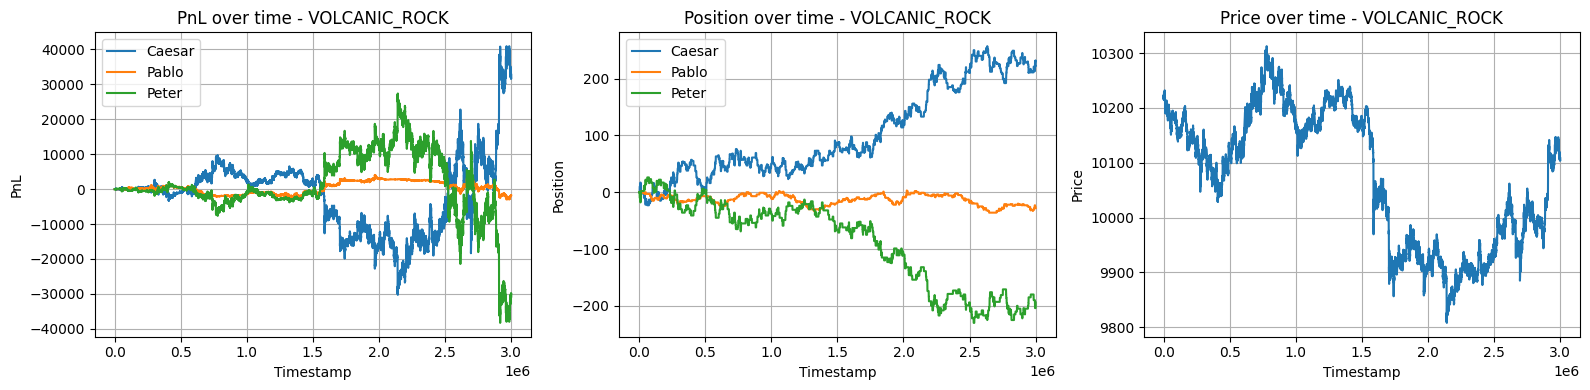

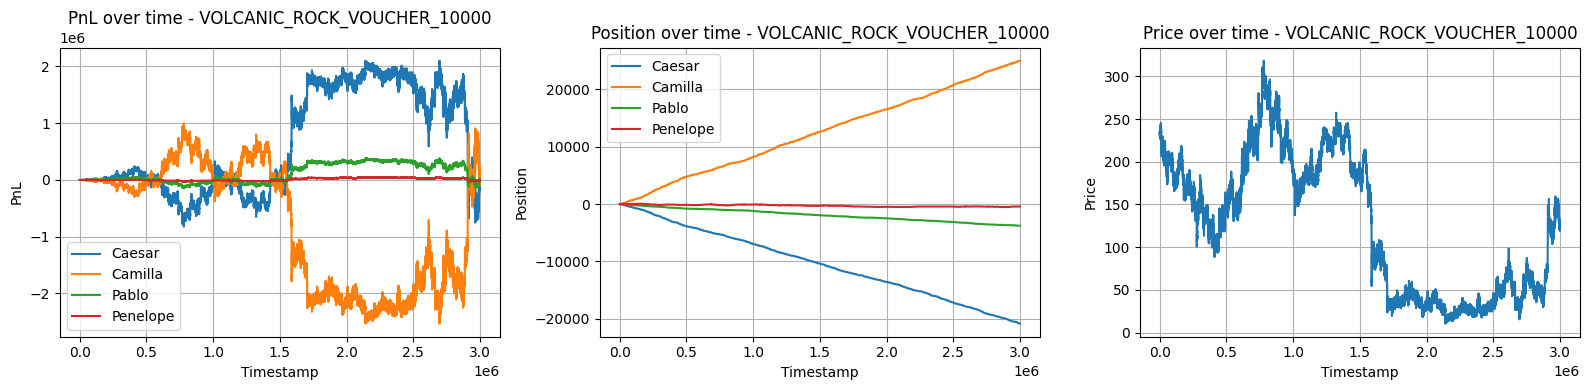

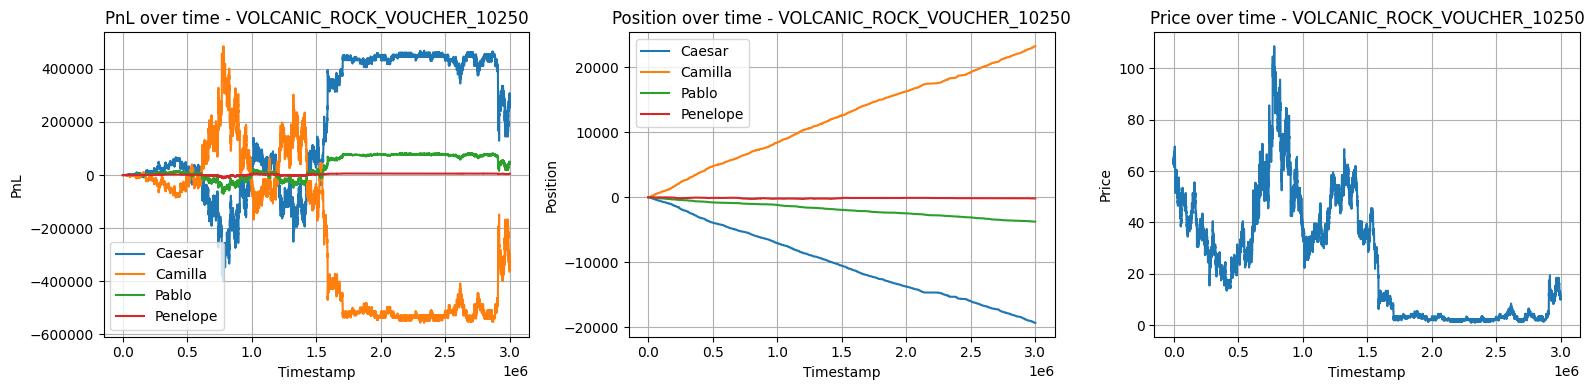

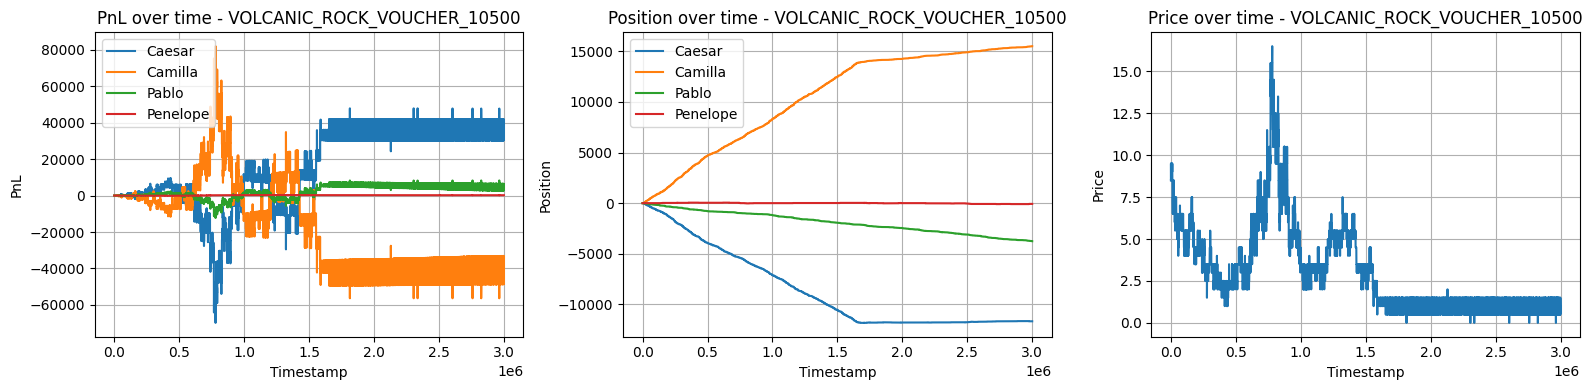

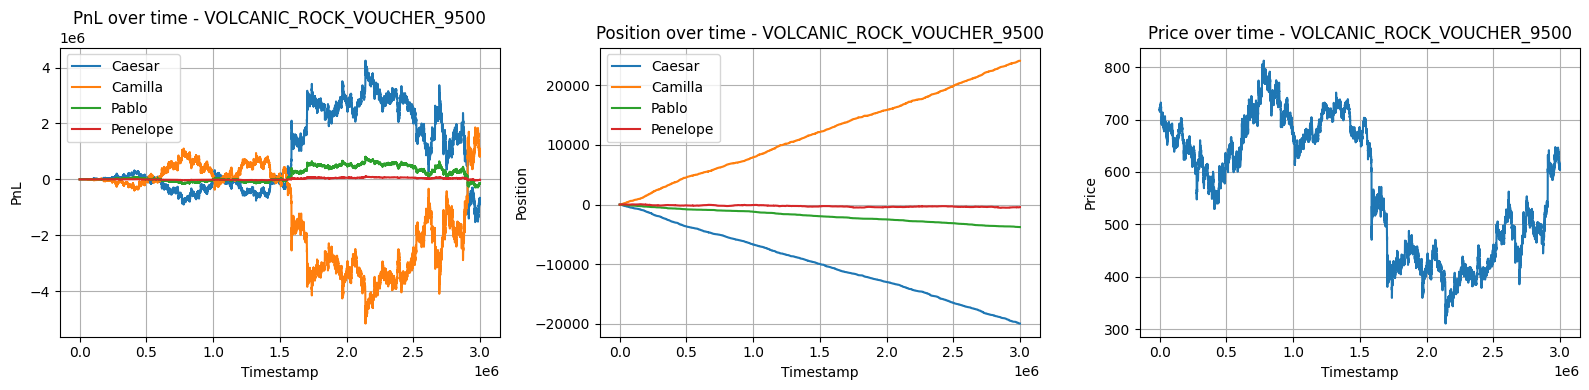

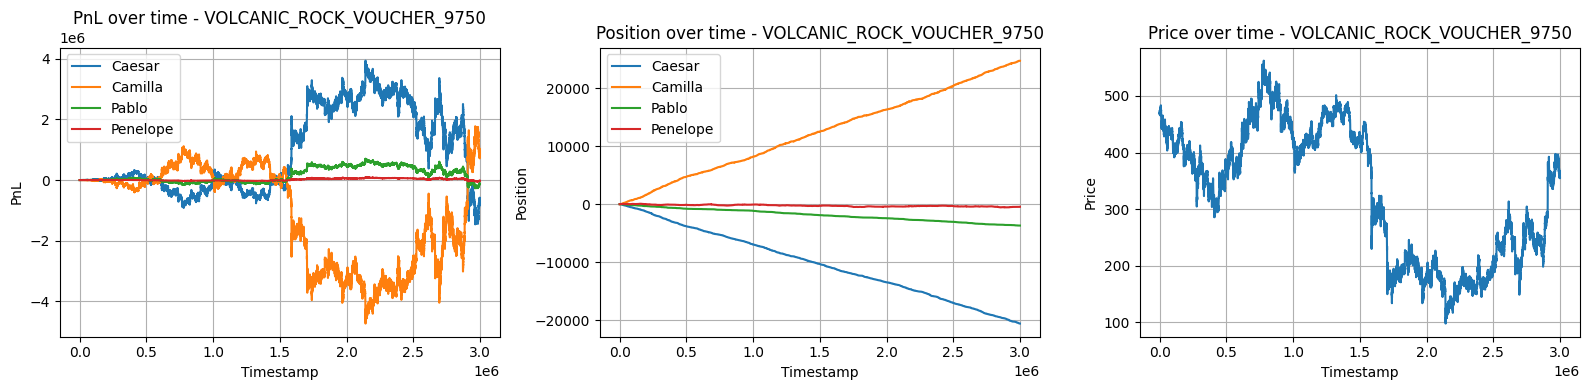

In [21]:



def calculate_pnl_position_over_time(trade_history, market_data, symbol):
    th_copy = trade_history[trade_history["symbol"] == symbol]

    timestamps = np.unique(market_data["timestamp"])
    cash = defaultdict(float)
    position = defaultdict(int)

    position_over_time = defaultdict(list)
    pnl_over_time = defaultdict(list)

    # collect all parties
    parties = np.unique(pd.concat([th_copy["buyer"], th_copy["seller"]]))
    for party in parties:
        position[party] = 0
        cash[party] = 0

    # collect midprices
    midprices = defaultdict(dict)
    for _, row in market_data.iterrows():
        midprices[row["product"]][row["timestamp"]] = row["mid_price"]

    # collect trades
    trades_at_timestamp = defaultdict(list)
    for _, trade in th_copy.iterrows():
        trades_at_timestamp[trade["timestamp"]].append(trade)

    # collect history
    for timestamp in timestamps:
        trades = trades_at_timestamp[timestamp]

        for trade in trades:
            position[trade["buyer"]] += trade["quantity"]
            position[trade["seller"]] -= trade["quantity"]

            cash[trade["buyer"]] -= trade["quantity"] * trade["price"]
            cash[trade["seller"]] += trade["quantity"] * trade["price"]

        for party in parties:
            pnl_over_time[party].append(cash[party] + position[party] * midprices[symbol][timestamp])
            position_over_time[party].append(position[party])

    return timestamps, position_over_time, pnl_over_time, parties


def plot_pnl_position_price_over_time(timestamps, position_over_time, pnl_over_time, price_over_time, parties, symbol):
    # plot the PNL and position side by side.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
    for party in parties:
        ax1.plot(timestamps, pnl_over_time[party], label=party)
        ax2.plot(timestamps, position_over_time[party], label=party)
    ax3.plot(timestamps, price_over_time)

    ax1.set_title(f"PnL over time - {symbol}")
    ax1.set_ylabel("PnL")
    ax1.set_xlabel("Timestamp")
    ax1.legend()
    ax1.grid(True)

    ax2.set_title(f"Position over time - {symbol}")
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Timestamp")
    ax2.legend()
    ax2.grid(True)

    ax3.set_title(f"Price over time - {symbol}")
    ax3.set_ylabel("Price")
    ax3.set_xlabel("Timestamp")
    ax3.grid(True)

    plt.tight_layout()
    plt.show()



# md2 = get_time_part(market_data_round_5_day_4, 0, 1e6)
# th2 = get_time_part(trades_round_5_day_4, 0, 1e6)

md2 = market_data_round_5_all3days.copy()
th2 = trades_round_5_all3days.copy()
# md2 = round4finallog.activities_log
# th2 = round4finallog.get_trade_history_as_df()


for product in sorted(np.unique(md2["product"])):
    ts, pos_t, pnl_t, parties = calculate_pnl_position_over_time(th2, md2, product)
    price_t = md2[md2["product"] == product]["mid_price"]
    plot_pnl_position_price_over_time(ts, pos_t, pnl_t, price_t, parties, product)

In [10]:

# for symbol in np.unique(th['symbol']):
#     th2 = th.copy()

#     th2 = th2[th2['symbol']==symbol]

#     th2.to_csv(f"{symbol}.csv")


Observations so far 
- Charlie is the market maker at 10000 +- 8 for RESIN.
- Some of these ppl are literally just going full limit long 
- Theres probably not much info from looking ONLY at the PNL & position graphs, have to dig deeper
- Caesar is the guy who keeps buying huge position of macarons


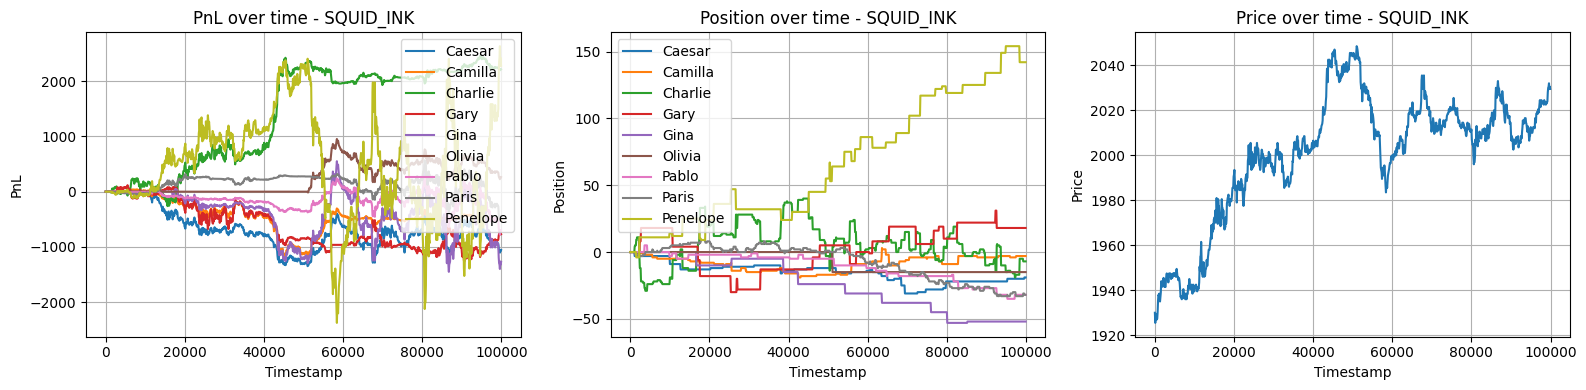

In [11]:
product =  SQUID_INK


md2 = get_time_part(md, 0, 1e5)
th2 = get_time_part(th, 0, 1e5)



ts, pos_t, pnl_t, parties = calculate_pnl_position_over_time(th2, md2, product)
price_t = md2[md2["product"] == product]["mid_price"]
plot_pnl_position_price_over_time(ts, pos_t, pnl_t, price_t, parties, product)

lets try something, lets try analyse the correlation between returns, and when (someone) buys. actually not correlation but more like distribution of returns. because for example we want to see what happens when caesar buys and sells squink. 

In [16]:
from tqdm.auto import tqdm


def calculate_thingy(product, party, lag, market_data, trade_history):
    md = market_data.copy()
    th = trade_history.copy()
    prices = md[md["product"] == product]["mid_price"].tolist()
    th = th[th["symbol"] == product]

    buy_sizes = []
    buy_pricereturns = []

    sell_sizes = []
    sell_pricereturns = []

    price_changes_since_buying = []
    price_changes_since_selling = []

    recent_sells = []
    recent_buys = []

    net_poschange = defaultdict(int) # map of timestamp to net pos change

    for _, trade in th.iterrows():
        ts = trade["timestamp"]
        pricenow = prices[int(ts / 100)]

        if (trade["buyer"] == party) ^ (trade["seller"] == party):
            if int(ts / 100) + lag < len(prices):
                pricereturn = prices[int(ts / 100) + lag] - pricenow

                if np.isnan(pricereturn) or np.isinf(pricereturn):
                    continue

                if trade["buyer"] == party:
                    buy_sizes.append(trade["quantity"])
                    buy_pricereturns.append(pricereturn)

                    for rs in recent_sells:
                        price_changes_since_selling.append(pricenow - rs)

                    recent_sells = []
                    recent_buys.append(pricenow)

                    net_poschange[ts] += trade['quantity']

                elif trade["seller"] == party:
                    sell_sizes.append(trade["quantity"])
                    sell_pricereturns.append(pricereturn)

                    for rb in recent_buys:
                        price_changes_since_buying.append(pricenow - rb)

                    recent_buys = []
                    recent_sells.append(pricenow)

                    net_poschange[ts] -= trade['quantity']

    mean_lag_buy_pricereturns = np.mean(buy_pricereturns)
    std_lag_buy_pricereturns = np.std(buy_pricereturns)

    mean_lag_sell_pricereturns = np.mean(sell_pricereturns)
    std_lag_sell_pricereturns = np.std(sell_pricereturns)

    buycorr = np.corrcoef(buy_sizes, buy_pricereturns)[0, 1]
    sellcorr = np.corrcoef(sell_sizes, sell_pricereturns)[0, 1]

    nb = len(buy_sizes)
    ns = len(sell_sizes)

    mean_buy_pricechange = np.mean(price_changes_since_buying)
    std_buy_pricechange = np.std(price_changes_since_buying)

    mean_sell_pricechange = np.mean(price_changes_since_selling)
    std_sell_pricechange = np.std(price_changes_since_selling)

    
    return {
        "mlbp": mean_lag_buy_pricereturns,
        "slbp": std_lag_buy_pricereturns,
        "mlsp": mean_lag_sell_pricereturns,
        "slsp": std_lag_sell_pricereturns,
        "mbp": mean_buy_pricechange,
        "sbp": std_buy_pricechange,
        "msp": mean_sell_pricechange,
        "ssp": std_sell_pricechange,
        "bc": buycorr,
        "sc": sellcorr,
        "nb": nb,
        "ns": ns,
    }


results = {}


done = 0
products = list(np.unique(market_data_round_5_day_4["product"]))
for product in products:
    marketdata = market_data_round_5_day_4.copy()
    trades = trades_round_5_day_4.copy()

    marketdata = marketdata[marketdata["product"] == product]
    trades = trades[trades["symbol"] == product]

    buyers = list(np.unique(trades["buyer"]))
    sellers = list(np.unique(trades["seller"]))
    parties = list(set(buyers + sellers))

    for party in parties:
        for lag in range(1, 100, 1):
            results[product, party, lag] = calculate_thingy(product, party, lag, marketdata, trades)

            done += 1
            # print(f"Done {done}/{len(products) * len(parties) * 50}")

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\numpy\core\_met

In [20]:
import math

sortkey = "mlbp"  # ← sort by e.g. buy correlation

filtered = [
    (k, v)
    for k, v in results.items()
    if not np.isnan(v[sortkey]) and v["nb"] >= 10 and v["ns"] >= 10 and k[0] == SQUID_INK and k[1] == "Gary"
]

sorted_results = sorted(filtered, key=lambda x: abs(x[1][sortkey]), reverse=True)

# Print the top 50
for i, (key, value) in enumerate(sorted_results[:500], 1):
    keystr = f"{i:2d}. (Product: {key[0]}, Party: {key[1]}), Lag: {key[2]} → "
    valuestr = ""

    for k, v in value.items():
        valuestr += f"{k}: {v:.4f} "

    print(keystr + valuestr)

 1. (Product: SQUID_INK, Party: Gary), Lag: 25 → mlbp: 1.6019 slbp: 6.0092 mlsp: -0.1489 slsp: 6.7854 mbp: -0.2850 sbp: 11.1653 msp: -0.3830 ssp: 11.7850 bc: 0.0691 sc: 0.0382 nb: 108.0000 ns: 94.0000 
 2. (Product: SQUID_INK, Party: Gary), Lag: 24 → mlbp: 1.5278 slbp: 5.7275 mlsp: -0.1436 slsp: 6.8574 mbp: -0.2850 sbp: 11.1653 msp: -0.3830 ssp: 11.7850 bc: 0.0599 sc: 0.0672 nb: 108.0000 ns: 94.0000 
 3. (Product: SQUID_INK, Party: Gary), Lag: 26 → mlbp: 1.5278 slbp: 6.3911 mlsp: -0.4681 slsp: 7.0890 mbp: -0.2850 sbp: 11.1653 msp: -0.3830 ssp: 11.7850 bc: 0.0683 sc: 0.0487 nb: 108.0000 ns: 94.0000 
 4. (Product: SQUID_INK, Party: Gary), Lag: 21 → mlbp: 1.5231 slbp: 5.6213 mlsp: 0.1915 slsp: 6.1194 mbp: -0.2850 sbp: 11.1653 msp: -0.3830 ssp: 11.7850 bc: 0.0330 sc: 0.0117 nb: 108.0000 ns: 94.0000 
 5. (Product: SQUID_INK, Party: Gary), Lag: 27 → mlbp: 1.5000 slbp: 6.0227 mlsp: -0.6170 slsp: 7.4016 mbp: -0.2850 sbp: 11.1653 msp: -0.3830 ssp: 11.7850 bc: 0.1118 sc: 0.0526 nb: 108.0000 ns: 

### gary seems to be somewhat informed on kelp?  
17. (Product: KELP, Party: Gary), Lag: 6 → mbl: 0.0917, sbl: 0.9958, msl: -0.0272, ssl: 0.7531, buy_corr: -0.3549, sell_corr: 0.4535, nb: 109.0000, ns: 92.0000
18. (Product: KELP, Party: Gary), Lag: 7 → mbl: 0.0413, sbl: 1.0319, msl: -0.1576, ssl: 0.8997, buy_corr: -0.2881, sell_corr: 0.4468, nb: 109.0000, ns: 92.0000



### charlie and camilla seem to be informed on picnic basket2. usually goes up when they buy and down when they sell. pablo and penelope are on the losing side of this trade.
 1. (Product: PICNIC_BASKET2, Party: Charlie), Lag: 48 → mlbp: 1.0002 slbp: 0.0006 mlsp: 1.0000 slsp: 0.0008 mbp: -1.8608 sbp: 67.9309 msp: -3.9655 ssp: 31.1692 bc: -0.0007 sc: 0.0131 nb: 79.0000 ns: 30.0000 
 2. (Product: PICNIC_BASKET2, Party: Charlie), Lag: 49 → mlbp: 1.0002 slbp: 0.0007 mlsp: 1.0000 slsp: 0.0009 mbp: -1.8608 sbp: 67.9309 msp: -3.9655 ssp: 31.1692 bc: 0.0052 sc: 0.0153 nb: 79.0000 ns: 30.0000 
 3. (Product: PICNIC_BASKET2, Party: Charlie), Lag: 47 → mlbp: 1.0002 slbp: 0.0006 mlsp: 1.0000 slsp: 0.0008 mbp: -1.8608 sbp: 67.9309 msp: -3.9655 ssp: 31.1692 bc: 0.0233 sc: -0.0076 nb: 79.0000 ns: 30.0000 
 241. (Product: PICNIC_BASKET2, Party: Pablo), Lag: 38 → mlbp: 0.9998 slbp: 0.0006 mlsp: 1.0001 slsp: 0.0006 mbp: -4.7652 sbp: 29.4538 msp: 11.5359 ssp: 43.2591 bc: -0.0974 sc: -0.0300 nb: 66.0000 ns: 170.0000 
242. (Product: PICNIC_BASKET2, Party: Pablo), Lag: 32 → mlbp: 0.9998 slbp: 0.0006 mlsp: 1.0001 slsp: 0.0006 mbp: -4.7652 sbp: 29.4538 msp: 11.5359 ssp: 43.2591 bc: -0.1035 sc: -0.0311 nb: 66.0000 ns: 170.0000 
243. (Product: PICNIC_BASKET2, Party: Pablo), Lag: 36 → mlbp: 0.9998 slbp: 0.0006 mlsp: 1.0001 slsp: 0.0006 mbp: -4.7652 sbp: 29.4538 msp: 11.5359 ssp: 43.2591 bc: -0.1229 sc: -0.0298 nb: 66.0000 ns: 170.0000 
 

### camilla (and caesar) seems to be an informed on picnic basket 1? usually goes up when they buy and down when they sell. penelope and pablo are on the losing side of this trade.
1. (Product: PICNIC_BASKET1, Party: Camilla), Lag: 1 → mbl: 1.2470, sbl: 5.0038, msl: -2.3776, ssl: 5.0290, buy_corr: -0.0646, sell_corr: 0.4363, nb: 166.0000, ns: 98.0000
2. (Product: PICNIC_BASKET1, Party: Camilla), Lag: 2 → mbl: 1.1687, sbl: 7.0705, msl: -2.9796, ssl: 5.9208, buy_corr: 0.0133, sell_corr: 0.3125, nb: 166.0000, ns: 98.0000
 
1. (Product: PICNIC_BASKET1, Party: Camilla), Lag: 1 → mlbp: 1.2470 slbp: 5.0038 mlsp: -2.3776 slsp: 5.0290 mbp: 8.4639 sbp: 39.9607 msp: -9.3763 ssp: 31.7001 bc: -0.0646 sc: 0.4363 nb: 166.0000 ns: 98.0000 
 2. (Product: PICNIC_BASKET1, Party: Camilla), Lag: 2 → mlbp: 1.1687 slbp: 7.0705 mlsp: -2.9796 slsp: 5.9208 mbp: 8.4639 sbp: 39.9607 msp: -9.3763 ssp: 31.7001 bc: 0.0133 sc: 0.3125 nb: 166.0000 ns: 98.0000 
 3. (Product: PICNIC_BASKET1, Party: Camilla), Lag: 3 → mlbp: 1.1476 slbp: 8.4167 mlsp: -3.1531 slsp: 7.3403 mbp: 8.4639 sbp: 39.9607 msp: -9.3763 ssp:  



### seems that whenever charlie buys macarons they go down in price. they usually are sold by paris. when paris buys they usually go up in price.
1. (Product: MAGNIFICENT_MACARONS, Party: Paris), Lag: 30 → mlbp: 1.0025 slbp: 0.0153 mlsp: 0.9995 slsp: 0.0160 mbp: -0.2542 sbp: 17.6721 msp: -2.5700 ssp: 18.8079 bc: -0.1653 sc: 0.1417 nb: 120.0000 ns: 151.0000 
 2. (Product: MAGNIFICENT_MACARONS, Party: Paris), Lag: 32 → mlbp: 1.0024 slbp: 0.0166 mlsp: 0.9996 slsp: 0.0161 mbp: -0.2542 sbp: 17.6721 msp: -2.5700 ssp: 18.8079 bc: -0.1827 sc: 0.1196 nb: 120.0000 ns: 151.0000 
 3. (Product: MAGNIFICENT_MACARONS, Party: Paris), Lag: 31 → mlbp: 1.0023 slbp: 0.0160 mlsp: 0.9994 slsp: 0.0162 mbp: -0.2542 sbp: 17.6721 msp: -2.5700 ssp: 18.8079 bc: -0.1849 sc: 0.1166 nb: 120.0000 ns: 151.0000 
 

91. (Product: MAGNIFICENT_MACARONS, Party: Charlie), Lag: 11 → mlbp: 0.9965 slbp: 0.0098 mlsp: 1.0014 slsp: 0.0099 mbp: -10.0769 sbp: 16.7077 msp: 12.5922 ssp: 56.8189 bc: 0.4813 sc: -0.1921 nb: 13.0000 ns: 118.0000 
92. (Product: MAGNIFICENT_MACARONS, Party: Charlie), Lag: 25 → mlbp: 0.9964 slbp: 0.0116 mlsp: 1.0021 slsp: 0.0135 mbp: -10.0769 sbp: 16.7077 msp: 12.5922 ssp: 56.8189 bc: 0.4006 sc: -0.0449 nb: 13.0000 ns: 118.0000 
93. (Product: MAGNIFICENT_MACARONS, Party: Charlie), Lag: 41 → mlbp: 0.9964 slbp: 0.0187 mlsp: 1.0015 slsp: 0.0186 mbp: -10.0769 sbp: 16.7077 msp: 12.5922 ssp: 56.8189 bc: -0.0633 sc: -0.2180 nb: 13.0000 ns: 118.0000  


### gina usually on the losing side of a squink trade, quite significantly too. for lag of ~40, gina has mlbp of 0.9986. gary is on the other side of these trades.
could use gina as an inverse squink index.


### charlie and camilla have nb and ns of ~1000, on squink which is huge,  definitely are marketmaking that.

turns out the result of +8mbp and -9 msp of camilla on picnic basket 1 is spurious. the reason the price changes this much after she buying and selling this much on average isn't because of directionality but instead because the spread is about 9-11 units, and she's market making. so its simply just her market making profits. 

found some stuff. but actually I realised this is quite a flawed way of checking which bots are informed because i'm having fixed lags.  

suppose we actually did have an informed market participant, and they were always buying low and selling high, the lags between them wouldn't be fixed, so if we did try test the corerlation of their direcitonality with lag x returns its likely we would'nt see that strong of a correlation.  


im hypothesisng theres some sort of hidden signal, like a trader that consistenyl loses money but is buying and selling and the right times (but just not in the correct volume).  




In [14]:
symbol = SQUID_INK
party = "Charlie"

market_data = market_data_round_5_day_4.copy()
trades = trades_round_5_day_4.copy()
trades = trades[trades["symbol"] == symbol]
trades = trades[(trades["buyer"] == party) ^ (trades["seller"] == party)]


# Filter market trades to symbol, then merge on timestamp
md_filtered = market_data[market_data["product"] == symbol][["timestamp", "bid_price_1", "ask_price_1"]]
trades = trades.merge(md_filtered, on="timestamp", how="left")


# Create boolean masks
mask_buy = trades["buyer"] == party
mask_sell = trades["seller"] == party

temp = mask_buy.copy()
mask_buy = mask_sell.copy()
mask_sell = temp.copy()

buy_value = np.sum(mask_buy * trades["ask_price_1"] * trades["quantity"])
sell_value = np.sum(mask_sell * trades["bid_price_1"] * trades["quantity"])


buy_qty = np.sum(mask_buy * trades["quantity"])
sell_qty = np.sum(mask_sell * trades["quantity"])

end_netpos = buy_qty - sell_qty


net_profit = end_netpos * market_data[market_data["product"] == symbol].iloc[-1]["mid_price"] - buy_value + sell_value

buy_qty, sell_qty, buy_value, sell_value, net_profit

(2773, 4056, 5481887.0, 8011482.0, 93819.5)

# lets visualise trades 


In [15]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# — your two DataFrames —
md_all = market_data_round_5_day_4.copy()
th_all = trades_round_5_day_4.copy()

# 1️⃣ Widgets
symbol_dd = widgets.Dropdown(
    options=sorted(md_all['product'].unique()), 
    description='Symbol:'
)
all_traders = sorted(set(th_all['buyer']).union(th_all['seller']))
checkboxes = [widgets.Checkbox(value=True, description=t) for t in all_traders]

controls = widgets.VBox([
    symbol_dd,
    widgets.Label("Show trades for:"),
    widgets.VBox(checkboxes)
])

out = widgets.Output(layout={'border': '1px solid lightgray'})

# 2️⃣ Plotting + hovertemplate
def update_plot(_=None):
    with out:
        clear_output(wait=True)
        sym = symbol_dd.value
        
        # filter
        md = md_all[md_all['product'] == sym]
        th = th_all[th_all['symbol'] == sym]
        
        fig = go.Figure()
        # bid/ask lines
        fig.add_trace(go.Scatter(
            x=md['timestamp'], y=md['bid_price_1'],
            mode='lines', name='bid_price_1'
        ))
        fig.add_trace(go.Scatter(
            x=md['timestamp'], y=md['ask_price_1'],
            mode='lines', name='ask_price_1'
        ))
        
        # which traders selected?
        sel = {cb.description for cb in checkboxes if cb.value}
        # filter trades once
        th_sel = th[ th['buyer'].isin(sel) | th['seller'].isin(sel) ]
        
        # add trade markers with both sides in hover
        for trader in sel:
            df_t = th_sel[(th_sel['buyer']==trader) | (th_sel['seller']==trader)]
            if df_t.empty:
                continue
            fig.add_trace(go.Scatter(
                x=df_t['timestamp'],
                y=df_t['price'],
                mode='markers',
                name=trader,
                customdata=df_t[['buyer','seller']],
                hovertemplate=(
                    "Buyer: %{customdata[0]}<br>"
                    "Seller: %{customdata[1]}<br>"
                    "Price: %{y}<br>"
                    "Time: %{x}<extra></extra>"
                )
            ))
        
        fig.update_layout(
            title=f"Trades + Bid/Ask for {sym}",
            xaxis_title="Timestamp",
            yaxis_title="Price",
            width=1600,    # ← new!
            height=1066     # ← bigger height
        )
        display(fig)

# 3️⃣ Wire up observers
symbol_dd.observe(update_plot, names='value')
for cb in checkboxes:
    cb.observe(update_plot, names='value')

# 4️⃣ Display
display(widgets.HBox([controls, out]))
update_plot()


for SQUINK, charlie and camilla are the market makers. everyone else just crosses the spread to get to them. charlie and camilla are top level, on a spread of like, 1 or 2.   
for DJEMBES, caesar and camilla are the market makerse, paris is the retail flow.  

currently what i'm seeing is that charlie, caesar, camilla are the main MM (although on some products they are not? idk - like, CAESAR is the one that is always filling our trades of size 75 on macaron)  
caesar also sometimes is a bum trader...  

camilla seems to be very consistent (nvm upon further inspection shes not a good signal, shes just a MM)  


These MM make me think that they are actually the same firm but like different pods, like for example when caesar and camilla are both MM we notice one goes super long one goes super short, if you think of them both as the same person, then they are collectively market making and staying delta neutral because one is super long and one is super short.  usually  in most of the graphs up at the very top we see one party go very long and one go very short, i think they, as a pair, are market making.  



# BIG FINDING

Olivia makes like 15 trades over 3 days. But she consistenly buys low sell high


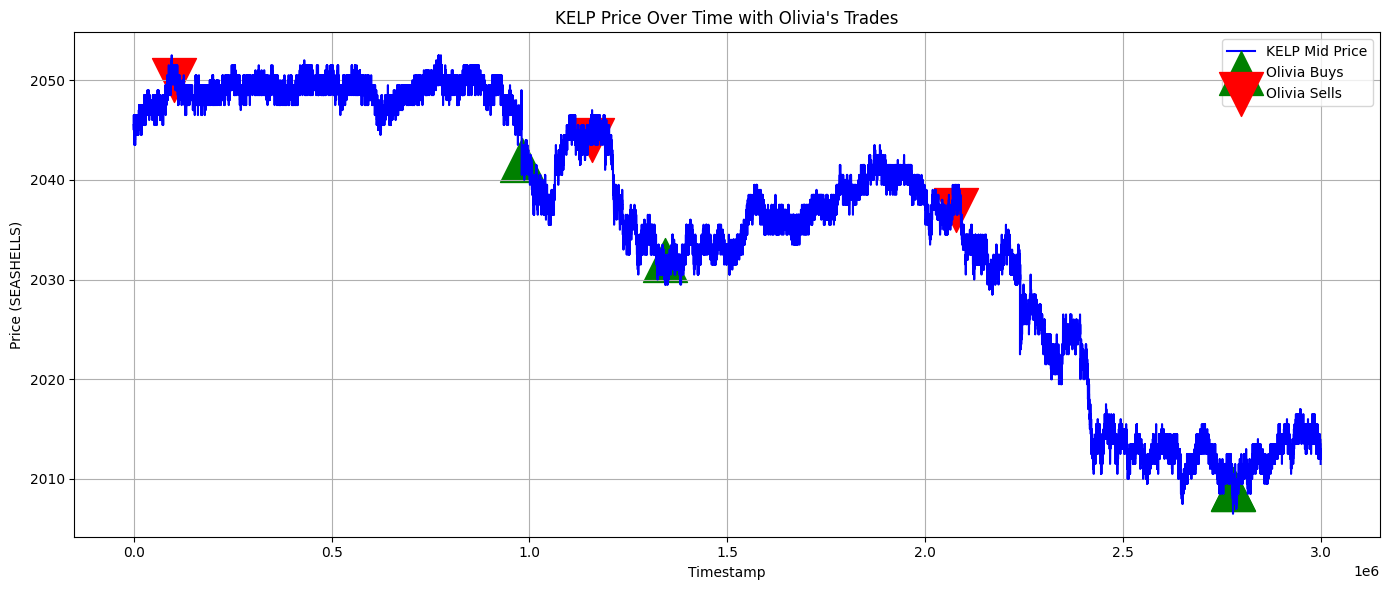

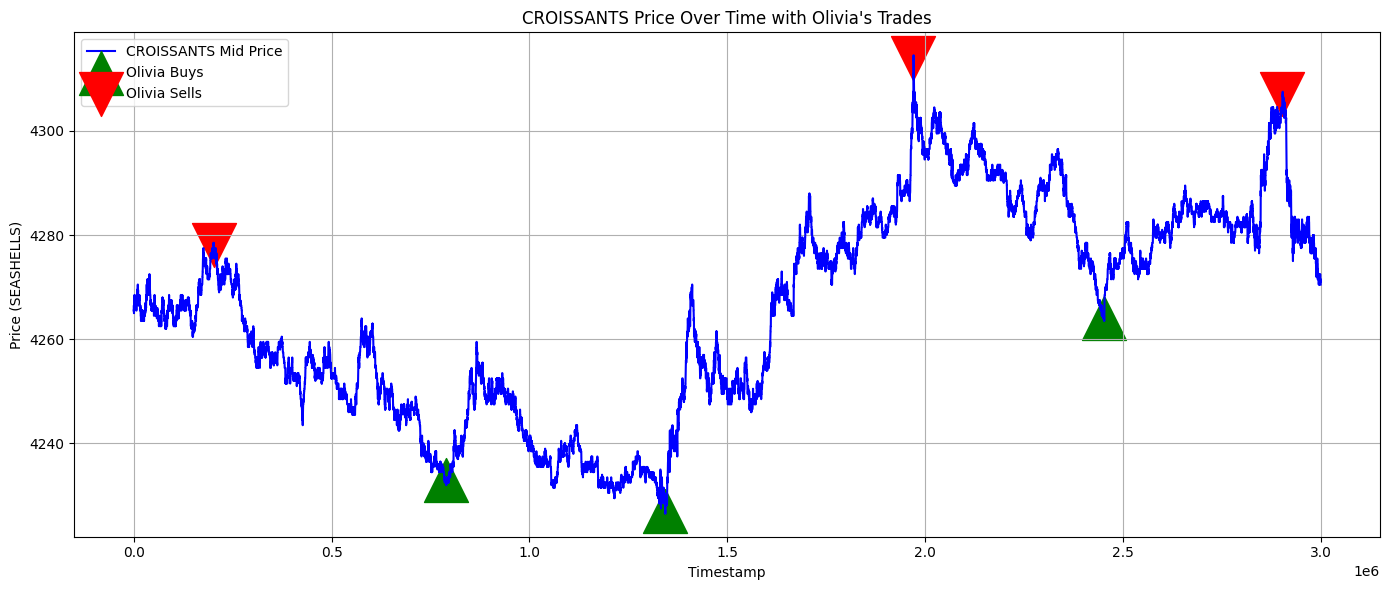

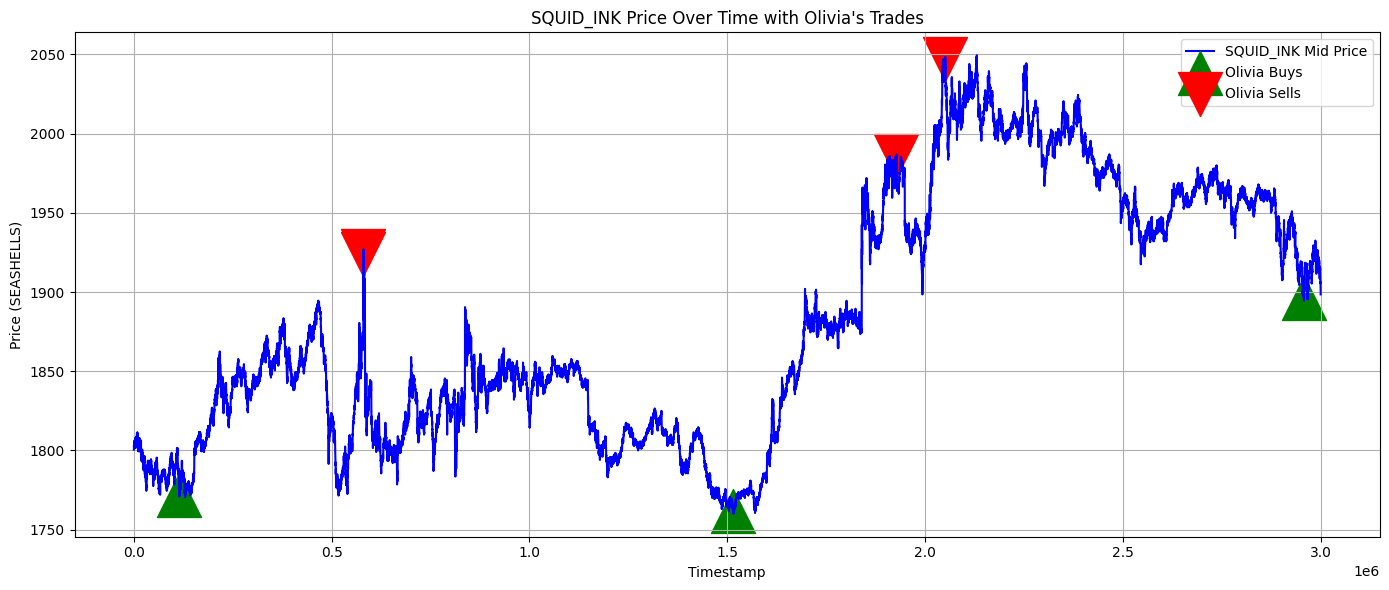

In [22]:
th = trades_round_5_all3days.copy()
md = market_data_round_5_all3days.copy()

import matplotlib.pyplot as plt
 
def plot_price_with_olivia_trades(product: str, md: pd.DataFrame, th: pd.DataFrame):
    # Filter market data for the selected product
    market = md[md["product"] == product]

    # Filter Olivia's trades for the selected product
    olivia_trades = th[(th["symbol"] == product) & ((th["buyer"] == "Olivia") | (th["seller"] == "Olivia"))]

    # Plot mid price over time
    plt.figure(figsize=(14, 6))
    plt.plot(market["timestamp"], market["mid_price"], label=f"{product} Mid Price", color="blue")

    # Mark Olivia's buys
    olivia_buys = olivia_trades[olivia_trades["buyer"] == "Olivia"]
    plt.scatter(olivia_buys["timestamp"], olivia_buys["price"], color="green", label="Olivia Buys", marker="^", s=1000)

    # Mark Olivia's sells
    olivia_sells = olivia_trades[olivia_trades["seller"] == "Olivia"]
    plt.scatter(olivia_sells["timestamp"], olivia_sells["price"], color="red", label="Olivia Sells", marker="v", s=1000)

    # Final touches
    plt.title(f"{product} Price Over Time with Olivia's Trades")
    plt.xlabel("Timestamp")
    plt.ylabel("Price (SEASHELLS)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_price_with_olivia_trades("KELP", md, th)
plot_price_with_olivia_trades("CROISSANTS", md, th)
plot_price_with_olivia_trades("SQUID_INK", md, th)